# Install dependecies

In [ ]:
!pip install gym
!pip install pip install stable-baselines3 gym numpy
!pip install shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
import gym
import torch
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import torch

import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# CNN

In [ ]:
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Calculate the shape of the flattened output from the CNN
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations):
        return self.linear(self.cnn(observations))

class CustomCnnPolicy(ActorCriticCnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, features_extractor_class=CustomCNN)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

# Updated RewardLoggingCallback
class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0

    def _on_step(self) -> bool:
        self.current_episode_reward += self.locals['rewards'][0]
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0
        return True

# Env

In [ ]:
class Game2048Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(Game2048Env, self).__init__()
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=2**16, shape=(1, 4, 4), dtype=np.int32)
        self.grid = self.init_grid()
        self.episode_reward = 0

    def init_grid(self):
        grid = np.zeros((4, 4), dtype=np.int32)
        for _ in range(2):
            self.add_new_tile(grid)
        return grid

    def add_new_tile(self, grid):
        empty_cells = list(zip(*np.where(grid == 0)))
        if empty_cells:
            x, y = empty_cells[np.random.randint(0, len(empty_cells))]
            grid[x, y] = 2 if np.random.random() < 0.9 else 4

    def reset(self):
        self.grid = self.init_grid()
        self.episode_reward = 0
        return self.grid[np.newaxis, :, :]  # Add channel dimension

    def step(self, action):
        if action not in [0, 1, 2, 3]:
            raise ValueError("Invalid Action")

        old_grid = self.grid.copy()
        self.move(action)
        if not np.array_equal(old_grid, self.grid):
            self.add_new_tile(self.grid)

        reward = self.calculate_reward()
        self.episode_reward += reward
        terminated = self.check_if_game_over()
        truncated = False
        info = {"episode_reward": self.episode_reward} if terminated else {}

        return self.grid[np.newaxis, :, :], reward, terminated, truncated, info  # Add channel dimension

    def move(self, action):
        if action == 0:  # up
            self.grid = self.move_up(self.grid)
        elif action == 1:  # down
            self.grid = self.move_down(self.grid)
        elif action == 2:  # left
            self.grid = self.move_left(self.grid)
        elif action == 3:  # right
            self.grid = self.move_right(self.grid)

    def move_up(self, grid):
        return np.array([self.collapse_column(grid[:, i]) for i in range(4)]).T

    def move_down(self, grid):
        return np.array([self.collapse_column(grid[:, i][::-1])[::-1] for i in range(4)]).T

    def move_left(self, grid):
        return np.array([self.collapse_column(grid[i, :]) for i in range(4)])

    def move_right(self, grid):
        return np.array([self.collapse_column(grid[i, :][::-1])[::-1] for i in range(4)])

    def collapse_column(self, col):
        col = col[col != 0]
        new_col = []
        skip = False
        for i in range(len(col)):
            if skip:
                skip = False
                continue
            if i + 1 < len(col) and col[i] == col[i + 1]:
                new_col.append(col[i] * 2)
                skip = True
            else:
                new_col.append(col[i])
        return np.array(new_col + [0] * (4 - len(new_col)))

    def calculate_reward(self):
        return np.max(self.grid)

    def check_if_game_over(self):
        if not np.any(self.grid == 0):
            for i in range(4):
                for j in range(4):
                    if i + 1 < 4 and self.grid[i, j] == self.grid[i + 1, j]:
                        return False
                    if j + 1 < 4 and self.grid[i, j] == self.grid[i, j + 1]:
                        return False
            return True
        return False

    def render(self, mode='human', close=False):
        print(self.grid)

# Train

In [ ]:
# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])

# Create the callback
reward_logging_callback = RewardLoggingCallback()

# Create the PPO model with the custom CNN policy
model = PPO(CustomCnnPolicy, env, verbose=1, device='cuda')  # Change 'auto' to 'cuda' to use GPU

# Train the model
model.learn(total_timesteps=1000000,callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_cnn")

# Load the model
model = PPO.load("ppo_2048_cnn")

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards

# Plot the rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 481  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------


KeyboardInterrupt: 

Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 1016         |
|    total_timesteps      | 434176       |
| train/                  |              |
|    approx_kl            | 0.0023208335 |
|    clip_fraction        | 0.0505       |
|    clip_range           | 0.107        |
|    entropy_loss         | -1.38        |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.000981     |
|    loss                 | 1.45e+05     |
|    n_updates            | 1266         |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 2.5e+05      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 427          |
|    iterations           | 213          |
|    time_elapsed         | 1021         |
|    total_timesteps      | 436224       |
| train/                  |              |
|    approx_kl            | 0.0024556231 |
|  

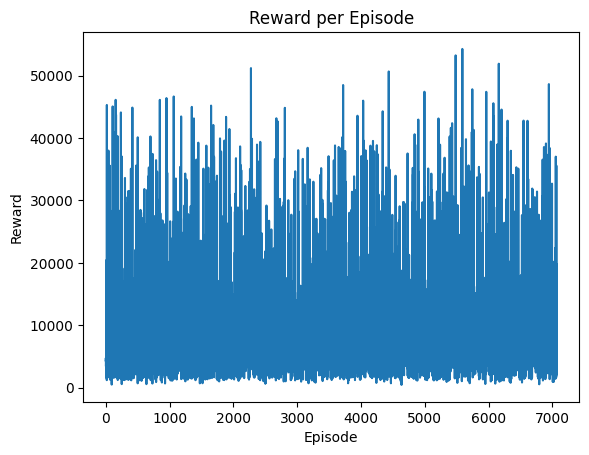

In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# Assuming Game2048Env and RewardLoggingCallback are already defined as provided previously

# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])

# Define hyperparameters

best_params = {'learning_rate': 0.0009810812751823298,
               'n_steps': 2048,
               'batch_size': 128,
               'n_epochs': 6,
               'gamma': 0.9815076624954892,
               'gae_lambda': 0.9105381858944547,
               'clip_range': 0.10747504799321428,
               'ent_coef': 0.08465940179821113,
               'vf_coef': 0.6131036454127421}

# Create the callback
reward_logging_callback = RewardLoggingCallback()

# Create the PPO model with the custom CNN policy
model = PPO(
    CustomCnnPolicy,
    env,
    verbose=1,
    device='cuda',  # Change 'auto' to 'cuda' to use GPU
    learning_rate=best_params['learning_rate'],
    n_steps=best_params['n_steps'],
    batch_size=best_params['batch_size'],
    n_epochs=best_params['n_epochs'],
    gamma=best_params['gamma'],
    gae_lambda=best_params['gae_lambda'],
    clip_range=best_params['clip_range'],
    ent_coef=best_params['ent_coef'],
    vf_coef=best_params['vf_coef']
)

# Train the model
model.learn(total_timesteps=1000000, callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_cnn")

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards

# Plot the rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

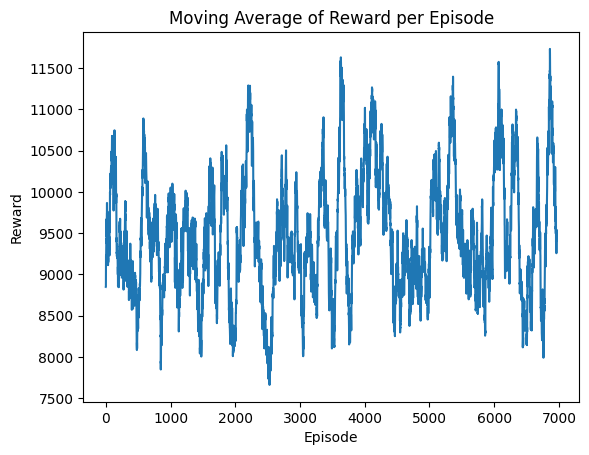

In [ ]:
# Plot the moving average of episode_rewards
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Moving Average of Reward per Episode')
plt.show()

# Load and test model

In [ ]:
!gdown 1eiFZKvbrnGbvZP2qDLJ4DWWTJzol4ElI

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Downloading...
From: https://drive.google.com/uc?id=1eiFZKvbrnGbvZP2qDLJ4DWWTJzol4ElI
To: /content/ppo_2048_cnn.zip
100% 1.55M/1.55M [00:00<00:00, 16.0MB/s]


In [ ]:
model = PPO.load("/content/ppo_2048_cnn.zip")

In [ ]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)

    env.render()
    if dones:
      break


[[0 0 0 0]
 [0 0 0 0]
 [0 4 0 0]
 [0 2 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 4 0 0]
 [0 2 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 4 0 0]
 [0 2 0 0]]
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 2]]
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 2]]
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 2]]
[[0 0 0 0]
 [2 0 0 0]
 [4 2 0 0]
 [2 0 0 0]]
[[0 0 0 0]
 [2 0 0 4]
 [4 0 0 0]
 [2 2 0 0]]
[[0 0 0 0]
 [2 0 2 0]
 [4 0 0 0]
 [2 2 0 4]]
[[0 0 0 0]
 [2 0 2 0]
 [4 0 0 0]
 [2 2 2 4]]
[[0 0 0 0]
 [4 0 0 0]
 [4 0 0 2]
 [4 2 4 0]]
[[0 4 0 0]
 [4 0 0 0]
 [4 2 0 0]
 [4 2 4 0]]
[[4 0 0 0]
 [0 0 0 0]
 [4 4 0 0]
 [8 4 4 0]]
[[0 0 0 0]
 [0 2 0 0]
 [8 0 0 0]
 [8 8 4 0]]
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  2  2  0]
 [16  8  4  0]]
[[ 0  2  0  0]
 [ 0  0  0  0]
 [ 0  0  0  4]
 [ 0 16  8  4]]
[[ 0  2  8  8]
 [ 0 16  0  0]
 [ 0  0  0  0]
 [ 2  0  0  0]]
[[ 0  0  0  0]
 [ 2  0  0  0]
 [ 0  2  0  0]
 [ 2 16  8  8]]
[[ 0  0  0  0]
 [ 2  0  0  0]
 [ 2  0  0  0]
 [ 2 16 16  2]]
[[ 0  0  0  0]
 [ 2  0  0  0]
 [ 2  0  0  0]
 [ 4 16 16  2]]
[[ 0

In [ ]:
rewards

array([280.], dtype=float32)

# Optuna

In [ ]:
import optuna
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0

    def _on_step(self) -> bool:
        self.current_episode_reward += self.locals['rewards'][0]
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0
        return True

def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    n_steps = trial.suggest_categorical('n_steps', [2048, 4096])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    n_epochs = trial.suggest_int('n_epochs', 3, 10)
    gamma = trial.suggest_uniform('gamma', 0.95, 0.99)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.9, 0.95)
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.3)
    ent_coef = trial.suggest_loguniform('ent_coef', 0.01, 0.1)
    vf_coef = trial.suggest_uniform('vf_coef', 0.5, 1.0)

    # Create the environment
    env = DummyVecEnv([lambda: gym.make('Game2048-v0')])

    # Create the PPO model
    model = PPO(
        CustomCnnPolicy,
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        n_epochs=n_epochs,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        verbose=0,
        device='cuda'
    )

    # Create the callback
    reward_logging_callback = RewardLoggingCallback()

    # Train the model
    model.learn(total_timesteps=100000, callback=reward_logging_callback)

    # Evaluate the model
    mean_reward = np.mean(reward_logging_callback.episode_rewards[-10:])
    return mean_reward

# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

[I 2024-05-15 20:49:16,861] A new study created in memory with name: no-name-dca5e59c-b52e-4189-aeee-b42ae1d3b94b
[I 2024-05-15 20:53:24,211] Trial 0 finished with value: 7046.6 and parameters: {'learning_rate': 2.6050402662831436e-05, 'n_steps': 4096, 'batch_size': 128, 'n_epochs': 6, 'gamma': 0.9636317914606859, 'gae_lambda': 0.9086950781885553, 'clip_range': 0.2362823965373347, 'ent_coef': 0.04429160056706058, 'vf_coef': 0.551628174766704}. Best is trial 0 with value: 7046.6.
[I 2024-05-15 20:57:19,822] Trial 1 finished with value: 12869.8 and parameters: {'learning_rate': 0.0009810812751823298, 'n_steps': 2048, 'batch_size': 128, 'n_epochs': 6, 'gamma': 0.9815076624954892, 'gae_lambda': 0.9105381858944547, 'clip_range': 0.10747504799321428, 'ent_coef': 0.08465940179821113, 'vf_coef': 0.6131036454127421}. Best is trial 1 with value: 12869.8.
[I 2024-05-15 21:01:14,273] Trial 2 finished with value: 11961.6 and parameters: {'learning_rate': 0.00028356520764612, 'n_steps': 4096, 'batch

KeyboardInterrupt: 

In [ ]:
best_params = {'learning_rate': 0.0009810812751823298,
               'n_steps': 2048,
               'batch_size': 128,
               'n_epochs': 6,
               'gamma': 0.9815076624954892,
               'gae_lambda': 0.9105381858944547,
               'clip_range': 0.10747504799321428,
               'ent_coef': 0.08465940179821113,
               'vf_coef': 0.6131036454127421}